# Homework 5

In [1]:
%pip install -U sklearn pandas imblearn matplotlib dalex

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 6.2 MB/s eta 0:00:0000:0100:01
  Created wheel for sklearn: filename=sklearn-0.0.post1-py3-none-any.whl size=2936 sha256=ca9479f2ae2228b248f1afa3886e40c18cd91be05a6f670df30b43d9622c2f17
  Stored in directory: /Users/maciej/Library/Caches/pip/wheels/c5/88/35/cc8a1e198b27a1d3d9d3f9b30090b9d5531778847835472ec4
Successfully built sklearn
  Attempting uninstall: sklearn
    Found existing installation: sklearn 0.0
    Uninstalling sklearn-0.0:
      Successfully uninstalled sklearn-0.0
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.6.1
    Uninstalling matplotlib-3.6.1:
      Successfully uninstalled matplotlib-3.6.1

[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: python3.10 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import functools

data = pd.read_csv("brain_stroke.csv")

data["ever_married"] = data["ever_married"] == "Yes"
data["urban"] = data["Residence_type"] == "Urban"
data = data.drop("Residence_type", axis=1)
data["male"] = data["gender"] == "Male"
data = data.drop("gender", axis=1)

def one_hot(data, column):
  return data.drop(column, axis=1).join(pd.get_dummies(data[column], prefix=column))

data = functools.reduce(one_hot, ["work_type", "smoking_status"], data)
data = data.rename(lambda x: x.lower(), axis=1)

data.head()

,age,hypertension,heart_disease,ever_married,avg_glucose_level,bmi,stroke,urban,male,work_type_govt_job,work_type_private,work_type_self-employed,work_type_children,smoking_status_unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,67.0,0,1,True,228.69,36.6,1,True,True,0,1,0,0,0,1,0,0
1,80.0,0,1,True,105.92,32.5,1,False,True,0,1,0,0,0,0,1,0
2,49.0,0,0,True,171.23,34.4,1,True,False,0,1,0,0,0,0,0,1
3,79.0,1,0,True,174.12,24.0,1,False,False,0,0,1,0,0,0,1,0
4,81.0,0,0,True,186.21,29.0,1,True,True,0,1,0,0,0,1,0,0


# Train/test split

In [5]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=0.1, random_state=1)
train_X, train_y = train.drop("stroke", axis=1), train["stroke"]
test_X, test_y = test.drop("stroke", axis=1), test["stroke"]

# reset indexes
train_X, train_y = train_X.reset_index(drop=True), train_y.reset_index(drop=True)
test_X, test_y = test_X.reset_index(drop=True), test_y.reset_index(drop=True)

# Logistic regression

Applied balanced class weight due to class imbalance.

In [6]:
from sklearn.linear_model import LogisticRegression

model_lr = LogisticRegression(max_iter=1000, class_weight="balanced", random_state=1).fit(train_X, train_y)

# Random forest

Similarly to previous, applied balanced class weight. Reduced max depth in order to prevent overfitting.

In [7]:
from sklearn.ensemble import RandomForestClassifier

model_rf = RandomForestClassifier(class_weight="balanced", max_depth=6, random_state=1).fit(train_X, train_y)

One without class weights:

In [11]:
model_rf_no_class_weights = RandomForestClassifier(max_depth=6, random_state=1).fit(train_X, train_y)

## Neural Network

In [20]:
from sklearn.neural_network import MLPClassifier
from imblearn.over_sampling import SMOTE

oversample = SMOTE()

X, y = oversample.fit_resample(train_X, train_y)

model_mlp = MLPClassifier(max_iter=100_000, hidden_layer_sizes=(7,)).fit(X, y)

### 1. Calculate Permutation-based Variable Importance for the selected model.

In [9]:
from dalex import Explainer

explainer = Explainer(model_rf, train_X, train_y, verbose=False)

explainer.model_performance()

/usr/local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


,recall,precision,f1,accuracy,auc
RandomForestClassifier,0.875556,0.178281,0.296241,0.791165,0.917913


In [10]:
pvi = explainer.model_parts(random_state=0)
pvi.plot()

### 2. Train three more candidate models (different variable transformations, different model architectures, hyperparameters) and compare their rankings of important features using PVI. What are the differences? Why?

In [14]:
explainer = Explainer(model_lr, train_X, train_y, verbose=False)
explainer.model_performance()

/usr/local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but LogisticRegression was fitted with feature names



,recall,precision,f1,accuracy,auc
LogisticRegression,0.826667,0.136765,0.2347,0.729362,0.840939


In [15]:
explainer.model_parts(random_state=1).plot()

In [17]:
explainer = Explainer(model_rf_no_class_weights, train_X, train_y, verbose=False)
explainer.model_performance()

/usr/local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but RandomForestClassifier was fitted with feature names



,recall,precision,f1,accuracy,auc
RandomForestClassifier,0.008889,1.0,0.017621,0.950245,0.927662


In [18]:
explainer.model_parts(random_state=1).plot()

In [23]:
explainer = Explainer(model_mlp, train_X, train_y, verbose=False)
explainer.model_performance()

/usr/local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but MLPClassifier was fitted with feature names



,recall,precision,f1,accuracy,auc
MLPClassifier,0.32,0.188482,0.237232,0.896698,0.796285


In [24]:
explainer.model_parts().plot()

For the tree-based model from (1), compare PVI with:

A) the traditional feature importance measures for trees: Gini impurity etc.; what is implemented in a given library: see e.g. the feature_importances_ attribute in xgboost and sklearn.
B) [in Python] SHAP variable importance based on the TreeSHAP algorithm available in the shap package.

<BarContainer object of 16 artists>

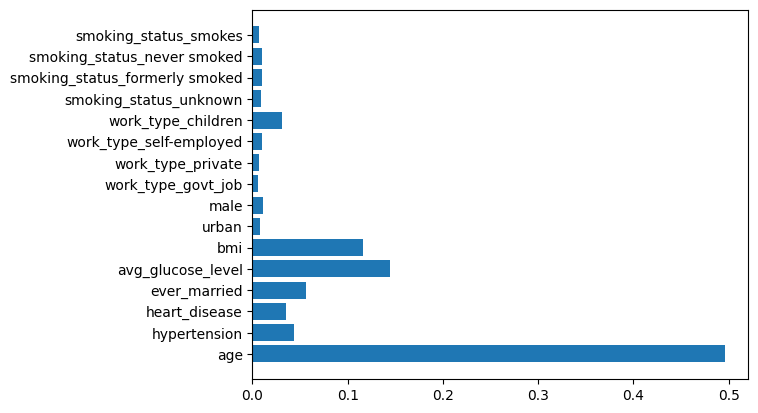

In [30]:
from matplotlib import pyplot as plt
plt.barh(train_X.columns, model_rf.feature_importances_)

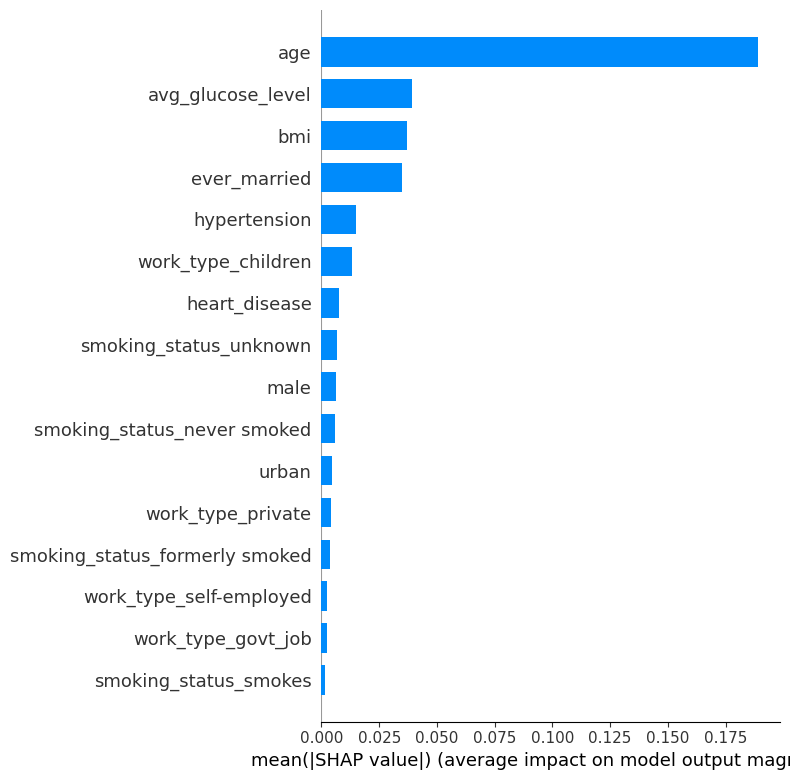

In [45]:
from shap.explainers import Tree
from shap import summary_plot

explainer = Tree(model_rf, )
shap_values = explainer.shap_values(train_X)
summary_plot(shap_values[0], train_X, plot_type="bar")